# Entorno de pruebas sobre el modelo
## Bibliotecas

In [1]:
#Aprendizaje por refuerzo
from gym import Env
from gym.spaces import Discrete, Box
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

#Red neuronal
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

#Arrays y operaciones aritméticas
import numpy as np
import random
import math

#Aplicación web
from werkzeug.wrappers import Request, Response
from werkzeug.serving import run_simple
from flask import Flask, render_template, request, redirect, url_for, flash
from wtforms import Form, FloatField, validators

#Gráficos e impresión por pantalla
import io
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import base64

## Entorno

In [2]:
class WindmillEnv(Env):
    def __init__(self, pRef):
        
        #Número de acciones
        self.action_space = Discrete(3)
        
        #Espacio de observación
        self.observation_space = Box(low=np.array([5]), high=np.array([14]))
        
        #Tiempo de entrenamiento
        self.training_length = 1000
        
        #Parámetros de la turbina
        #Variables estáticas
        self.wind_density = 1.225
        self.radious = 2
        self.wind = 10.0
        self.powerRef = pRef
        
        #Variables dinámicas
        self.angle = random.uniform(5.0, 14.0)
        self.power_eficiency = (-0.0422)*self.angle + 0.5911
        self.genPowerEuler = 0.5*self.wind_density*math.pi*pow(self.radious, 2)*pow(self.wind, 3)*self.power_eficiency
        self.error = abs(self.powerRef - self.genPowerEuler)
    
    
    def step(self, action):
        
        powerRefCheck = self.powerRef
        
        #Guardamos el error del paso anterior
        last_error = self.error
        
        #Reducimos el tiempo de entrenamiento en 1 segundo
        self.training_length -= 1
        
        #Aplicamos la acción tomada
        self.angle += (action/10.0) - 0.01
         
        #Linealizamos el modelo de la turbina
        for t in range(1, 151):
            self.power_eficiency = (-0.0422)*self.angle + 0.5911
            self.genPowerEuler += ((0.5*self.wind_density*math.pi*pow(self.radious, 2)*pow(self.wind, 3)
                                    *self.power_eficiency)/5 - self.genPowerEuler/5)*0.5
        
        
        
        #Calculamos el error actual
        self.error = abs(powerRefCheck - self.genPowerEuler)
        
        #Calculamos la recompensa
        if self.error < last_error:
            reward = 1 - (self.error/10)
        if self.error > last_error:
            reward = -100 - (self.error/10)
        else:
            reward = -50 - (self.error/10)
            
        #Comprobamos si el tiempo de entrenamiento ha llegado a 0
        if self.training_length <= 0:
            done = True
        else:
            done = False
                
        #Info
        info = {}
        
        return self.angle, reward, done, info
    
    #Función para resetear los parámetros dinámicos
    def reset(self):
        
        self.angle = random.uniform(5, 14)
        self.power_eficiency = (-0.0422)*self.angle + 0.5911
        self.genPowerEuler = 0.5*self.wind_density*math.pi*pow(self.radious, 2)*pow(self.wind, 3)*self.power_eficiency
        self.error = abs(self.powerRef - self.genPowerEuler)
        
        self.training_length = 1000
        
        return self.angle
    
    
    #GETTERS Y SETTERS
    #Potencia de referencia
    @property
    def powerRefMethod(self):
        return self.powerRef
    
    @powerRefMethod.setter
    def powerRefMethod(self, powerRefv):
        self.powerRef = powerRefv
    
    
    #Potencia generada
    @property
    def genPowerEulerMethod(self):
        return self.genPowerEuler
    
    @genPowerEulerMethod.setter
    def genPowerEulerMethod(self, genPowerEulerv):
        self.genPowerEuler = genPowerEulerv
    
    
    #Ángulo
    @property
    def angleMethod(self):
        return self.angle
    
    @angleMethod.setter
    def angleMethod(self, anglev):
        self.angle = anglev
    
    
    #Tiempo de entrenamiento
    @property
    def training_lengthMethod(self):
        return self.training_length
    
    @training_lengthMethod.setter
    def training_lengthMethod(self, training_lengthv):
        self.training_length = training_lengthv
        
    

In [3]:
#Instanciamos el entorno en una variable
env = WindmillEnv(1000)
states = env.observation_space.shape
actions = env.action_space.n

C:\Users\dgarr\anaconda3\lib\site-packages\gym\logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


## Red neuronal

In [4]:
#Función para crer el modelo de la red neuronal
def build_model(states, actions):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape = states))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [5]:
model = build_model(states, actions)

## Agente

In [6]:
#Función para crear el agente
def build_agent(model, actions):
    memory = SequentialMemory(limit=30000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=BoltzmannQPolicy(), nb_actions=actions, nb_steps_warmup=1000)
    return dqn

## Entrenamiento

In [7]:
#Compilación y entrenamiento del agente
dqn = build_agent(model, actions)
dqn.compile(Adam(learning_rate=1e-3), metrics=['mae'])
dqn.fit(env, nb_steps=20000, visualize=False, verbose=1)

Training for 20000 steps ...
Interval 1 (0 steps performed)
   80/10000 [..............................] - ETA: 14s - reward: -222.3337

C:\Users\dgarr\anaconda3\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


10000/10000 [==============================] - 64s 6ms/step - reward: -394.8646
10 episodes - episode_reward: -394864.622 [-1284765.296, -128526.600] - loss: 12498.576 - mae: 441.743 - mean_q: -601.280

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 70s 7ms/step - reward: -106.5442
done, took 133.599 seconds


## Pruebas

Episode:1 Score:-155368.05709331686 Steps:2000 Final Power:1006.7358383975588


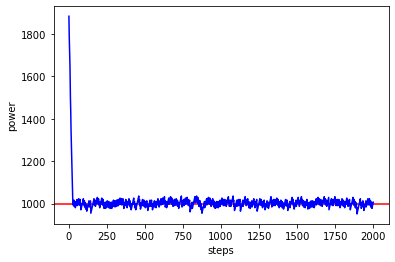

In [9]:
episodes = 1
powerArray = []
anglesArray = []

for episode in range(1, episodes+1):
    obs = env.reset()
    done = False
    score = 0
    env.training_lengthMethod = 2000
    initTrainingLenght = env.training_lengthMethod
    
    powerArray.append(env.genPowerEuler)
    anglesArray.append(env.angleMethod)
    
    while not done:
        action = dqn.forward(obs)
        obs, reward, done, info = env.step(action)
        score += reward
            
        powerArray.append(env.genPowerEuler)
        anglesArray.append(env.angleMethod)
        
    print('Episode:{} Score:{} Steps:{} Final Power:{}'.format(episode, score, initTrainingLenght - env.training_lengthMethod, env.genPowerEuler))
    
plt.xlabel("steps")
plt.ylabel("power")
plt.axhline(y=env.powerRefMethod, color='r', linestyle='-')
plt.plot(powerArray, 'b')
plt.show()